In [ ]:
pip install pyspark pandas yfinance scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285387 sha256=b1c715c6c4b48d89b9481f9ca6f2a858d45fd66f07a5308c9fc13b16eef187b0
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
import yfinance as yf
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [ ]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr

In [ ]:

yf.pdr_override()

# Create a Spark session
spark = SparkSession.builder.appName("StockPricePrediction").getOrCreate()

# ["AAPL", "GOOGL", "MSFT", "AMZN", "NFLX"]

# Fetch historical AAPL stock price data from Yahoo Finance using pandas_datareader
start_date = '2005-01-01'
end_date = '2023-09-14'
a_df = yf.download('AAPL', start=start_date, end=end_date)
g_df = yf.download('GOOGL', start=start_date, end=end_date)
m_df = yf.download('MSFT', start=start_date, end=end_date)
am_df = yf.download('AMZN', start=start_date, end=end_date)
n_df = yf.download('NFLX', start=start_date, end=end_date)
# df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
spark = SparkSession.builder.appName("StockPrediction").getOrCreate()

In [ ]:
company_list = ["AAPL", "GOOGL", "MSFT", "AMZN", "NFLX"]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON","NETFLIX"]

In [ ]:
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

yf.pdr_override()

In [ ]:
# Descriptive Statistics about the Data

# .describe() generates descriptive statistics.

# Descriptive statistics include those that summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values.

# Analyzes both numeric and object series, as well as DataFrame column sets of mixed data types.

# The output will vary depending on what is provided. Refer to the notes below for more detail

In [ ]:
g_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4.706000e+03
mean,41.199353,41.632027,40.766110,41.207724,41.207724,1.167752e+08
std,37.167762,37.593842,36.760406,37.183471,37.183471,1.433293e+08
min,4.386887,4.464464,4.318569,4.379129,4.379129,9.312000e+06
25%,13.152965,13.264952,12.994682,13.154155,13.154155,3.190100e+07
50%,27.177000,27.378250,26.954249,27.148000,27.148000,6.363416e+07
75%,57.265749,57.770376,56.700376,57.344875,57.344875,1.411577e+08
max,151.250000,151.546494,148.899002,149.838501,149.838501,1.643023e+09


In [ ]:
a_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4.706000e+03
mean,42.928854,43.402896,42.469521,42.954610,41.354170,4.087473e+08
std,51.072603,51.665725,50.518545,51.116019,51.143532,3.994064e+08
min,1.139107,1.159107,1.117857,1.130179,0.959292,3.145820e+07
25%,6.719286,6.786875,6.626786,6.717053,5.701411,1.119174e+08
50%,23.177500,23.338214,22.956429,23.137143,20.258852,2.663238e+08
75%,48.301250,48.783751,48.004375,48.378125,46.495269,5.909008e+08
max,196.240005,198.229996,195.279999,196.449997,196.185074,3.372970e+09


In [ ]:
am_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4.706000e+03
mean,46.010619,46.552748,45.420239,45.997283,45.997283,1.092193e+08
std,53.193090,53.826946,52.494637,53.157256,53.157256,9.194455e+07
min,1.304500,1.315000,1.288000,1.303500,1.303500,1.762600e+07
25%,4.634750,4.705000,4.560625,4.644625,4.644625,6.088000e+07
50%,16.289750,16.473001,16.096750,16.282750,16.282750,8.725300e+07
75%,87.142252,87.969753,86.065374,86.989622,86.989622,1.300235e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,2.086584e+09


In [ ]:
n_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4.706000e+03
mean,145.846913,148.127393,143.491864,145.875086,145.875086,1.594771e+07
std,175.848811,178.391399,173.144727,175.809282,175.809282,1.824888e+07
min,1.300000,1.317143,1.272857,1.290000,1.290000,1.144000e+06
25%,6.547857,6.688928,6.454643,6.587143,6.587143,6.076725e+06
50%,53.347857,53.966429,52.077143,53.036428,53.036428,9.933400e+06
75%,288.745003,293.550003,283.220001,288.919998,288.919998,1.884435e+07
max,692.349976,700.989990,686.090027,691.690002,691.690002,3.155418e+08


In [ ]:
g_df.describe()['Close']

count    4706.000000
mean       41.207724
std        37.183471
min         4.379129
25%        13.154155
50%        27.148000
75%        57.344875
max       149.838501
Name: Close, dtype: float64

In [ ]:
# Information About the Data

# .info()

# method prints information about a DataFrame including the index dtype and columns, non-null values, and memory usage.

In [ ]:
m_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2005-01-03 to 2023-09-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       4706 non-null   float64
 1   High       4706 non-null   float64
 2   Low        4706 non-null   float64
 3   Close      4706 non-null   float64
 4   Adj Close  4706 non-null   float64
 5   Volume     4706 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 257.4 KB


In [ ]:
# Closing Price

# The closing price is the last price at which the stock is traded during the regular trading day.

# A stock’s closing price is the standard benchmark used by investors to track its performance over time.

In [ ]:
for _,comp in enumerate([a_df,g_df,m_df,am_df,n_df]):
  print(len(comp))

4706
4706
4706
4706
4706


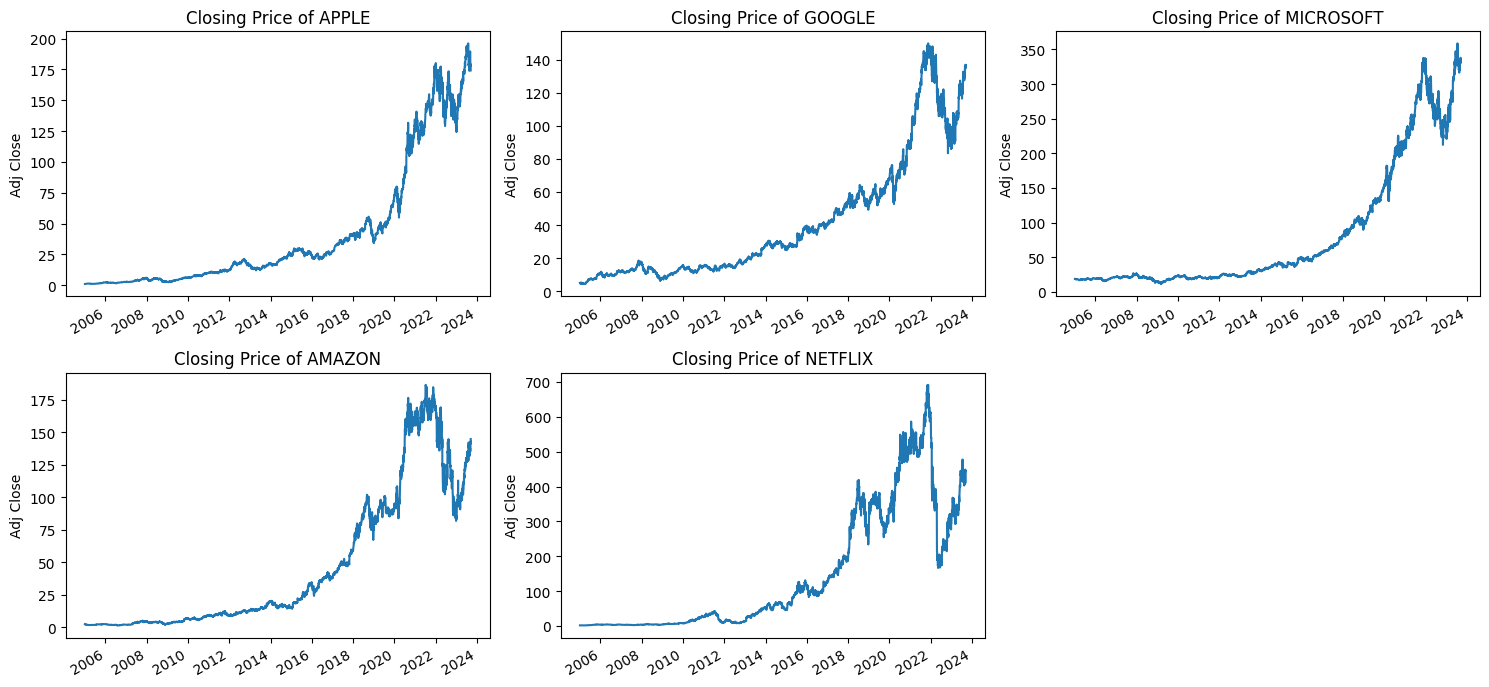

In [ ]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, comp in enumerate([a_df,g_df,m_df,am_df,n_df]):
    plt.subplot(3, 3, i+1)
    comp['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {company_name[i]}")

plt.tight_layout()

In [ ]:
# Volume of Sales

# Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day.

# For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close.

# Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

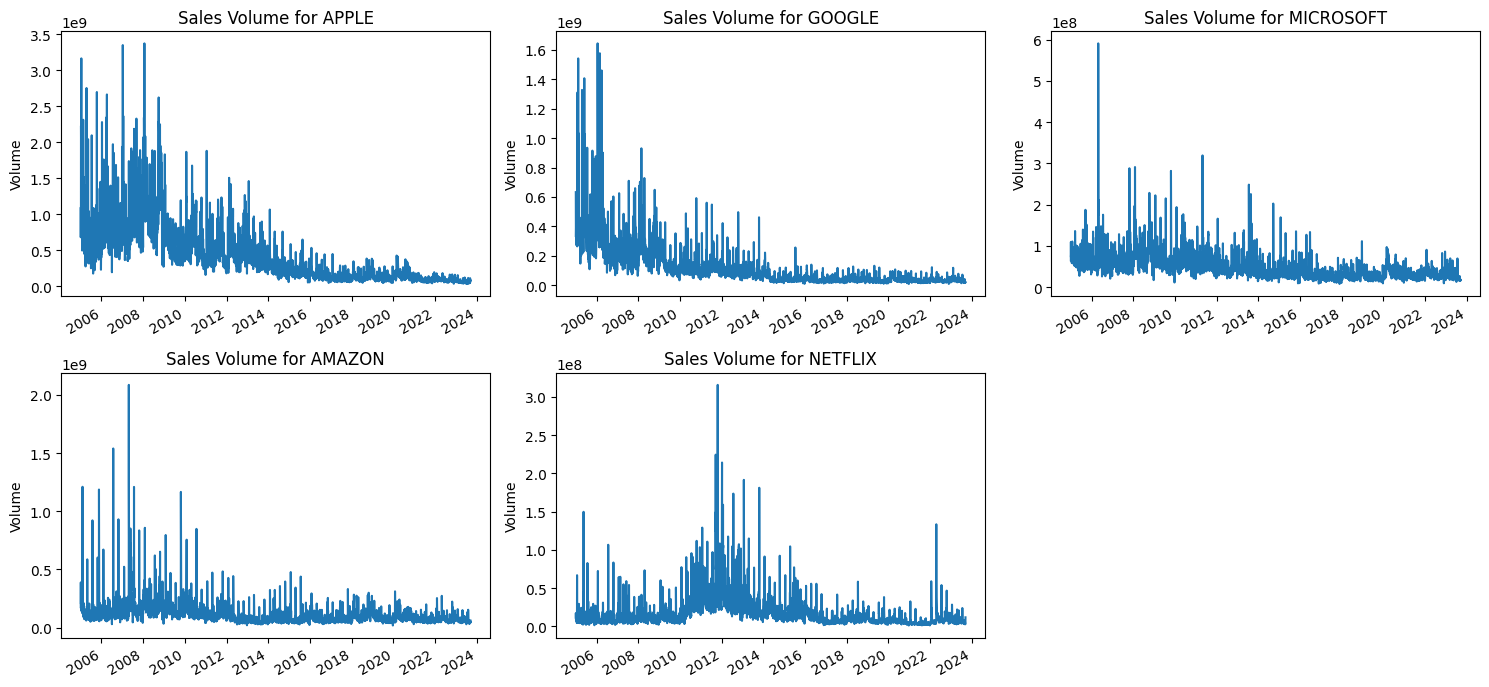

In [ ]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, comp in enumerate([a_df,g_df,m_df,am_df,n_df]):
    plt.subplot(3, 3, i+1)
    comp['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {company_name[i]}")

plt.tight_layout()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.ml.evaluation import RegressionEvaluator
from datetime import datetime
import pandas_datareader as pdr
from pyspark.ml.regression import DecisionTreeRegressor

In [ ]:
def sparkDF(df):
  # Convert the pandas DataFrame to a PySpark DataFrame
  spark_df = spark.createDataFrame(df.reset_index())

  # Feature selection and engineering
  feature_columns = ["Volume", "Open", "High", "Low"]
  assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
  spark_df = assembler.transform(spark_df)

  # Filter data for the training set (up to the end of 2021)
  train_data = spark_df.filter(spark_df["Date"] < "2022-01-01")

  # Filter data for the test set (from the beginning of 2022 until the present)
  test_data = spark_df.filter(spark_df["Date"] >= "2022-01-01")
  return train_data,test_data

In [ ]:
def lr(train_data,test_data):
  # Create and train a linear regression model
  lr = LinearRegression(labelCol="Close", featuresCol="features")
  lr_model = lr.fit(train_data)

  # Make predictions on the test data
  predictions = lr_model.transform(test_data)

  # Evaluate the model
  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(predictions)

  return lr_model,predictions,rmse

In [ ]:
def randomForReg(train_data,test_data):
# Create and train a Random Forest regression model
  rf = RandomForestRegressor(labelCol="Close", featuresCol="features", numTrees=100)
  model = rf.fit(train_data)

  # Make predictions on the test data
  predictions = model.transform(test_data)

  # Evaluate the model
  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(predictions)
  return model,predictions,rmse

In [ ]:
def GBT(train_data,test_data):
  # Gradient-Boosted Trees
  gbt = GBTRegressor(labelCol="Close", featuresCol="features", maxIter=10)
  model = gbt.fit(train_data)

  # Make predictions on the test data
  predictions = model.transform(test_data)

  # Evaluate the model
  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(predictions)
  return model,predictions,rmse

In [ ]:
def DTR(train_data,test_data):
  # Create and train a Decision Tree Regressor model
  dt = DecisionTreeRegressor(labelCol="Close", featuresCol="features")
  model = dt.fit(train_data)

  # Make predictions on the test data
  predictions = model.transform(test_data)

  # Evaluate the model
  from pyspark.ml.evaluation import RegressionEvaluator

  evaluator = RegressionEvaluator(labelCol="Close", predictionCol="prediction", metricName="rmse")
  rmse = evaluator.evaluate(predictions)
  return model,predictions,rmse

In [ ]:
df = pd.DataFrame(columns=["","APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "NETFLIX"])

In [ ]:
funs = [lr,randomForReg,GBT,DTR]
for index,m in enumerate(["Linear_Regression","Random_Forest_Regressor","Gradient_Boosted_Trees","Decision_Tree_Regressor"]):
  data = [m]
  fun = funs[index]
  for i,d in enumerate([a_df,g_df,m_df,am_df,n_df]):
    train,test = sparkDF(d)
    model,_, rmse = fun(train,test)
    data.append(rmse)
    # print(data)
  new_row_df = pd.DataFrame([data], columns=df.columns)
  df = df.append(new_row_df)

<ipython-input-27-04daea483a40>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row_df)
<ipython-input-27-04daea483a40>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row_df)
<ipython-input-27-04daea483a40>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row_df)
<ipython-input-27-04daea483a40>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row_df)


In [ ]:
df

,,APPLE,GOOGLE,MICROSOFT,AMAZON,NETFLIX
0,Linear_Regression,1.042396,0.884439,1.954219,1.099960,3.655038
0,Random_Forest_Regressor,18.012516,9.340756,19.834590,11.156920,19.383701
0,Gradient_Boosted_Trees,18.241668,10.197231,22.855515,11.123856,22.573054
0,Decision_Tree_Regressor,17.895329,10.082680,22.887084,11.194488,22.914921


In [ ]:
df.to_excel('/content/drive/MyDrive/bd/report/rmse.xlsx')

<ipython-input-38-52602748d01f>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lr_df = lr_df.append(new_row_df)


In [ ]:
def scetch_graph(predictions):
  # Convert the predictions DataFrame to pandas for plotting
  predictions_df = predictions.select("Date", "Close", "prediction").toPandas()

  # Create a subplot for visualizing the predicted vs. real closing prices
  plt.figure(figsize=(12, 6))
  plt.plot(predictions_df["Date"], predictions_df["Close"], label="Real Closing Price", linestyle="-", marker="o")
  plt.plot(predictions_df["Date"], predictions_df["prediction"], label="Predicted Closing Price", linestyle="-", marker="o")
  plt.title("Real vs. Predicted AAPL Closing Prices")
  plt.xlabel("Date")
  plt.ylabel("Closing Price")
  plt.legend()
  plt.grid(True)

In [ ]:
lr_model.save('/content/lr')

In [ ]:
train,test = sparkDF(a_df)
model,pred,_ = lr(train,test)

In [ ]:
from scipy.stats import spearmanr
sp_df = pd.DataFrame(columns=["","APPLE", "GOOGLE", "MICROSOFT", "AMAZON", "NETFLIX"])
models = []
spearman = ['spearman']
p_vals = ['p_val']
for i,d in enumerate([a_df,g_df,m_df,am_df,n_df]):
  train,test = sparkDF(d)
  model,pred,_ = lr(train,test)
  close = pred.select('Close').rdd.flatMap(lambda x: x).collect()
  predic = pred.select('Prediction').rdd.flatMap(lambda x: x).collect()
  spearman_corr, p_val = spearmanr(close, predic)
  models.append(model)
  spearman.append(spearman_corr)
  p_vals.append(p_val)
sp = pd.DataFrame([spearman], columns=sp_df.columns)
pv = pd.DataFrame([p_vals], columns=sp_df.columns)
sp_df = sp_df.append(sp)
sp_df = sp_df.append(pv)

<ipython-input-55-4019a76e0634>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sp_df = sp_df.append(sp)
<ipython-input-55-4019a76e0634>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sp_df = sp_df.append(pv)


In [ ]:
sp_df

,,APPLE,GOOGLE,MICROSOFT,AMAZON,NETFLIX
0,spearman,0.997638,0.998297,0.998216,0.998687,0.998702
0,p_val,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
sp_df.to_excel('/content/drive/MyDrive/bd/report/spearman.xlsx')

using streaming data

In [ ]:
# importing required libraries
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.streaming import StreamingContext
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DateType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler

In [ ]:
# initializing spark session
spark = SparkSession.builder.master("local").appName("Stream").config('spark.ui.port', '4050').getOrCreate()

schema = StructType([
    StructField("Date", DateType(), True),
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Adj Close", DoubleType(), True),
    StructField("Volume", StringType(), True)
])




In [ ]:
# Fetch historical AMZN stock price data from Yahoo Finance using pandas_datareader
start_date = '2005-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')
df = yf.download('AAPL', start=start_date, end=end_date)

# Convert the pandas DataFrame to a PySpark DataFrame
my_data = spark.createDataFrame(df.reset_index(), schema=schema)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Filter data for the training set (up to the end of 2021)
train_data = my_data.filter(my_data["Date"] < "2022-01-01")

# Filter data for the test set (from the beginning of 2022 until the present)
test_data = my_data.filter(my_data["Date"] >= "2022-01-01")

In [ ]:
# print the schema of the file
train_data.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: string (nullable = true)



In [ ]:
# Feature engineering and preprocessing
feature_columns = ["Open", "High", "Low"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
feature_data = assembler.transform(train_data)

In [ ]:
# Data Preprocessing Stage 2: Standard Scaling for Features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaled_data = scaler.fit(feature_data).transform(feature_data)

In [ ]:
# Create and train a linear regression model
lr = LinearRegression(labelCol="Close", featuresCol="features")

In [ ]:
# Create a pipeline for the entire process
pipeline = Pipeline(stages=[assembler, scaler, lr])

In [ ]:
# fit the pipeline model with the training data
pipelineFit = pipeline.fit(train_data)

In [ ]:
model_path = "/content/lr2"
pipelineFit.write().overwrite().save(model_path)

In [ ]:
# Load the saved pipeline model
loaded_pipeline_model = PipelineModel.load("/content/lr2")

In [ ]:
# Apply the pipeline model for real-time predictions on streaming data
streaming_predictions = loaded_pipeline_model.transform(streaming_data)

In [ ]:
# Define the output sink for the streaming predictions (write to CSV)
output_directory = "/content/test3"  # Specify the directory where CSV files will be saved
query = (streaming_predictions.select("Date","Close","prediction")
  .writeStream
  .outputMode("append")
  .format("csv")
  .option("checkpointLocation", "/content/drive/MyDrive/bd/checkpoint_dir3")
  .option("path", output_directory)
  .start()
  .awaitTermination())

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
predictions_df = pd.read_csv('/content/test3/part-00000-89a66653-6438-439f-a26c-6e4e3f299e44-c000.csv')
predictions_df.columns = ["Date","Close","Prediction"]

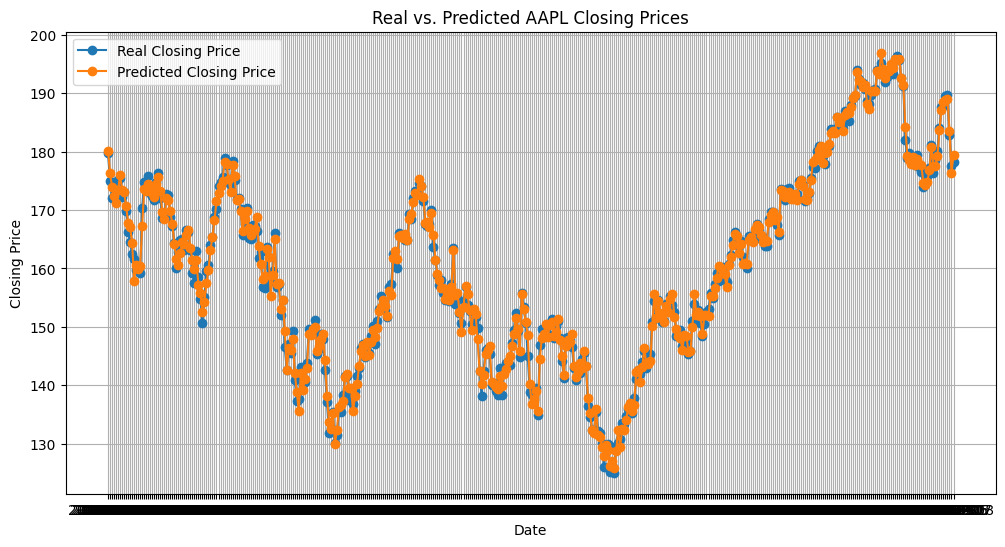

In [ ]:
# Create a subplot for visualizing the predicted vs. real closing prices
plt.figure(figsize=(12, 6))
plt.plot(predictions_df["Date"], predictions_df["Close"], label="Real Closing Price", linestyle="-", marker="o")
plt.plot(predictions_df["Date"], predictions_df["Prediction"], label="Predicted Closing Price", linestyle="-", marker="o")
plt.title("Real vs. Predicted AAPL Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)